In [1]:
!pip install tqdm
!pip install transformers datasets
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot
from numpy import inf
from sklearn.utils.class_weight import compute_class_weight
from torchinfo import summary
from tqdm import tqdm
from transformers import AdamW, ViTFeatureExtractor, ViTModel
import torchvision.transforms as transforms

In [3]:
from torch.utils.data import TensorDataset,DataLoader,random_split
from torchvision.datasets import ImageFolder
import os
data_dir = './data/cifar10'

print(os.listdir(path = data_dir + '/train'))
classes = os.listdir(path = data_dir + '/train')
print(classes)
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

train_dataset = ImageFolder(root=train_dir,transform=transforms.Compose([
                                                        transforms.Resize((224,224)),
                                                        transforms.ToTensor()]))
test_dataset = ImageFolder(root=test_dir,transform=transforms.Compose([
                                                        transforms.Resize((224,224)),
                                                        transforms.ToTensor()]))

Data_available = len(train_dataset)
training_data_size = int(0.85*Data_available)
validation_data_size = Data_available - training_data_size
print(training_data_size,validation_data_size)
train_dl,val_dl = random_split(train_dataset,lengths=[training_data_size,validation_data_size])

['horse', 'dog', 'ship', 'frog', 'truck', 'deer', 'airplane', 'automobile', 'cat', 'bird']
['horse', 'dog', 'ship', 'frog', 'truck', 'deer', 'airplane', 'automobile', 'cat', 'bird']
42500 7501


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# create dataloaders
train_batch_size = 64
eval_batch_size = train_batch_size*2
train_dataloader = torch.utils.data.DataLoader(train_dl, batch_size=train_batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dl, batch_size=eval_batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=eval_batch_size, num_workers=2)

In [5]:
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
for param in vit_model.parameters():
      param.requires_grad = False
class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=10):
        super(ViTForImageClassification, self).__init__()
        self.vit = vit_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size,num_labels)
        self.num_labels = num_labels
    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)
        return logits
model = ViTForImageClassification()
model = model.to(device)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

In [8]:
cross_entropy = nn.CrossEntropyLoss()

In [9]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)
# number of training epochs
epochs = 50

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
# function to train the model
def train():
  
    model.train()
    total_loss = 0
    # empty list to save model predictions
    total_preds=[]
    # iterate over batches
    for step,(pix,lbl) in enumerate(train_dataloader):
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(train_dataloader)))
        
        # push the batch to gpu
        # print(batch)
        # lbl, pix = batch
        lbl, pix = lbl.to(device), pix.to(device)
        #print(pix.shape)
        
        # get model predictions for the current batch
        preds = model(pix)
       
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, lbl)
        
        # add on to the total loss
        total_loss = total_loss + loss.item()
        
        # backward pass to calculate the gradients
        loss.backward()
        
        # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update parameters
        optimizer.step()
        
        # clear calculated gradients
        optimizer.zero_grad()  
        preds=preds.detach().cpu().numpy()
        
        # append the model predictions
        total_preds.append(preds)
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
    total_preds  = np.concatenate(total_preds, axis=0)
    
    #returns the loss and predictions
    return avg_loss, total_preds

In [11]:
def eval():
    total_loss = 0
    model.eval() # prep model for evaluation
    for step,(pix,lbl) in enumerate(val_dataloader):
        lbl, pix = lbl.to(device), pix.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        preds = model(pix)
        # calculate the loss
        loss = cross_entropy(preds, lbl)
        total_loss += loss.item()
    
    return total_loss / len(val_dataloader)

In [12]:
min_loss = inf
es = 0
training_loss = []
validation_loss = []
for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Train model
    train_loss, _ = train()
    val_loss = eval()
    
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    
    # Early Stopping
    if val_loss < min_loss:
        min_loss = val_loss
        es = 0
    else:
        es += 1
        if es > 4:
            print("Early stopping with train_loss: ", train_loss, "and val_loss for this epoch: ", val_loss, "...")
            break
    
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f'\n Training Loss: {train_loss:.3f}')
    print(f'\n Validation Loss: {val_loss:.3f}')


 Epoch 1 / 50
  Batch    50  of    665.
  Batch   100  of    665.
  Batch   150  of    665.
  Batch   200  of    665.
  Batch   250  of    665.
  Batch   300  of    665.
  Batch   350  of    665.
  Batch   400  of    665.
  Batch   450  of    665.
  Batch   500  of    665.
  Batch   550  of    665.
  Batch   600  of    665.
  Batch   650  of    665.

 Training Loss: 0.519

 Validation Loss: 0.294

 Epoch 2 / 50
  Batch    50  of    665.
  Batch   100  of    665.
  Batch   150  of    665.
  Batch   200  of    665.
  Batch   250  of    665.
  Batch   300  of    665.
  Batch   350  of    665.
  Batch   400  of    665.
  Batch   450  of    665.
  Batch   500  of    665.
  Batch   550  of    665.
  Batch   600  of    665.
  Batch   650  of    665.

 Training Loss: 0.271

 Validation Loss: 0.255

 Epoch 3 / 50
  Batch    50  of    665.
  Batch   100  of    665.
  Batch   150  of    665.
  Batch   200  of    665.
  Batch   250  of    665.
  Batch   300  of    665.
  Batch   350  of    665.
 

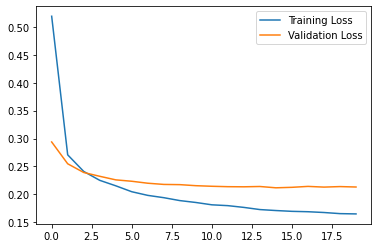

In [13]:
import matplotlib.pyplot as plt

plt.plot(training_loss,label="Training Loss")
plt.plot(validation_loss,label="Validation Loss")
plt.legend()

In [14]:
torch.save(model.state_dict(), '/models')

In [15]:
def eval():
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for step, (pix,lbl) in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
            lbl, pix = lbl.to(device), pix.to(device)
            outputs = model(pix)
            outputs = torch.argmax(outputs, axis=1)
            y_pred.extend(outputs.cpu().detach().numpy())
            y_true.extend(lbl.cpu().detach().numpy())
            
    return y_pred, y_true
y_pred, y_true = eval()

100%|██████████| 79/79 [01:14<00:00,  1.07it/s]


In [16]:
correct = np.array(y_pred) == np.array(y_true)
accuracy = correct.sum() / len(correct)
print("Accuracy of the model", accuracy)

Accuracy of the model 0.9301
